
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496

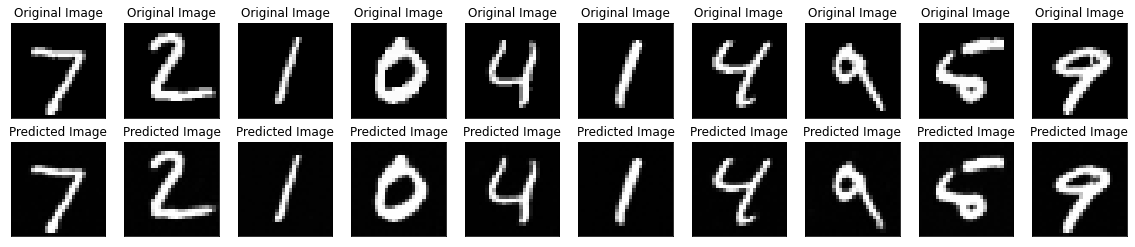

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
print("")

## Seeding
np.random.seed(42)
tf.random.set_seed(42)

## Loading the dataset and then normalizing the images.
# dataset = tf.keras.datasets.fashion_mnist
dataset = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = dataset.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Hyperparameters
H = 28
W = 28
C = 1

## Latent space
latent_dim = 128

## Building the autoencoder
inputs = Input(shape=(H, W, C), name="inputs")
x = inputs

x = Conv2D(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent")(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)

outputs = x

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

print(x_train.shape, x_test.shape)

autoencoder.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=256,
    shuffle=False,
    validation_data=(x_test, x_test)
)

test_pred_y = autoencoder.predict(x_test)

n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("Original Image")
    plt.imshow(x_test[i].reshape(H, W))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title("Predicted Image")
    plt.imshow(test_pred_y[i].reshape(H, W))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("res/convolutional_autoencoder.png")